In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import os
from tqdm.auto import tqdm
from numba import njit,prange
import scipy

# loading all of the csv's from all of the simulations with the macro measured data (total energy, ent. excess, Paccept....)
simlist = []
datafiles = []
csvfiles = []
for root, dirs, files in os.walk("../data/pdanneal/"):
    for file in files:
        if file.endswith(".npz"):
            datafiles.append(os.path.join(root,file))
        if file.endswith(".csv"):
            csvfiles.append(os.path.join(root,file))
    for name in dirs:
        simlist.append(name)
simlist = sorted(simlist)
datafiles = sorted(datafiles)
csvfiles = sorted(csvfiles)
print(len(simlist))
print(len(datafiles))
print(len(csvfiles))
assert len(simlist) == len(datafiles) == len(csvfiles)


def load_csv(fname,verbose=True):
    if verbose:
        with open(fname) as f:
            print(f.readline().strip('\n'))
    return np.loadtxt(fname,skiprows=1,delimiter=",")

                                
@njit
def calc_s_corr(s,nshells):
    g = np.zeros(nshells)
    c = np.zeros(nshells)
    ni,nj,nk = s.shape
    s_avg2 = np.mean(s)**2
    for i in range(ni):
        for j in range(nj):
            for k in range(nk):
                #print(i,j,k)
                for di in np.arange(-nshells,nshells+1):
                    for dj in np.arange(-nshells,nshells+1):
                        for dk in np.arange(-nshells,nshells+1):
                            r2 = di*di + dj*dj + dk*dk
                            if r2 < nshells*nshells:
                                rr = np.sqrt(r2)
                                ii = i + di
                                jj = j + dj
                                kk = k + dk
                                if (ii < ni) and (jj < nj) and (kk < nk) and (ii >= 0) and (jj >= 0) and (kk >= 0):
                                    ishell = int(np.floor(rr))
                                    #assert ishell > 0
                                    g[ishell] = g[ishell] + s[i,j,k] * s[ii,jj,kk] - s_avg2
                                    c[ishell] += 1
    for ishell in np.arange(nshells):
        g[ishell] = g[ishell]/c[ishell]# - s_avg2
    return g,c

def plot_s_corr(fpath,g,savedir=None):
    nshells = len(g)
    if savedir is not None:
        newpath = os.path.join(os.getcwd(),savedir)
        if os.path.isdir(newpath):
            print("dir already exists")
            return
        else:
            os.makedirs(newpath)
    fig,ax = plt.subplots()
    ax.set_title(fpath.split("/")[-2])
    ax.plot(np.arange(1,nshells+1),g)
    ax.set_ylabel("Chiral Correlation")
    ax.set_xlabel("Shells")
    if savedir is not None:
        plt.savefig(os.path.join(newpath,fpath.split("/")[-2]+".png"))
    else:
        plt.show()

def plot_corr_fit(fpath,g,savedir=None):
    nshells = len(g)
    if savedir is not None:
        newpath = os.path.join(os.getcwd(),savedir)
        if os.path.isdir(newpath):
            pass
        else:
            os.makedirs(newpath)
    a,l = fit_corr_exp2(g)
    nshells = len(g)
    fig,ax = plt.subplots()
    ax.set_title(datafile.split("/")[-2])
    ax.plot(np.arange(1,nshells+1),g)
    ax.plot(np.arange(1,nshells+1),func2(np.arange(nshells),a,l),label="a="+str(np.round(a,5))+"\nL="+str(np.round(l,5))+"\nc="+str(np.round(c,5)))
    #ax.plot(np.arange(nshells),func(np.arange(nshells),0.1,1))
    ax.set_ylabel("Chiral Correlation")
    ax.set_xlabel("Shells")
    ax.legend()
    plt.show()
    if savedir is not None:
        plt.savefig(os.path.join(newpath,fpath.split("/")[-2]+"_fit.png"))
    else:
        plt.show()

def plot_corr_fitc(fpath,g,savedir=None):
    nshells = len(g)
    if savedir is not None:
        newpath = os.path.join(os.getcwd(),savedir)
        if os.path.isdir(newpath):
            pass
        else:
            os.makedirs(newpath)
    a,l,c = fit_corr_exp1c(g)
    nshells = len(g)
    fig,ax = plt.subplots()
    ax.set_title(datafile.split("/")[-2])
    ax.plot(np.arange(1,nshells+1),g)
    ax.plot(np.arange(1,nshells+1),func1c(np.arange(nshells),a,l,c),label="a="+str(np.round(a,5))+"\nL="+str(np.round(l,5))+"\nc="+str(np.round(c,5)))
    #ax.plot(np.arange(nshells),func(np.arange(nshells),0.1,1))
    ax.set_ylabel("Chiral Correlation")
    ax.set_xlabel("Shells")
    ax.legend()
    plt.show()
    if savedir is not None:
        plt.savefig(os.path.join(newpath,fpath.split("/")[-2]+"_fitc.png"))
    else:
        plt.show()

def func1(x, a, l):
    return a * np.exp(-x/l)

def func1c(x, a, l, c):
    return a * np.exp(-x/l) + c

def func2(x,a,l):
    return (a/x)*np.exp(-x/l)

def func2c(x,a,l):
    return (a/x)*np.exp(-x/l) + c

def fit_corr_exp1(g):
    nshells = len(g)
    popt,pcov = scipy.optimize.curve_fit(func1,np.arange(nshells),g)
    return popt[0],popt[1]

def fit_corr_exp1c(g):
    nshells = len(g)
    popt,pcov = scipy.optimize.curve_fit(func1c,np.arange(nshells),g)
    return popt[0],popt[1],popt[2]

def fit_corr_exp2(g):
    nshells = len(g)
    popt,pcov = scipy.optimize.curve_fit(func2,np.arange(nshells),g)
    return popt[0],popt[1]

def fit_corr_exp2c(g):
    nshells = len(g)
    popt,pcov = scipy.optimize.curve_fit(func2c,np.arange(nshells),g)
    return popt[0],popt[1],popt[2]

    
%matplotlib ipympl
print(len(datafiles))

390
390
390
390


../data/pdanneal/pdanneal_K1.0_kbt0.05/pdanneal_K1.0_kbt0.05_data.npz


[]

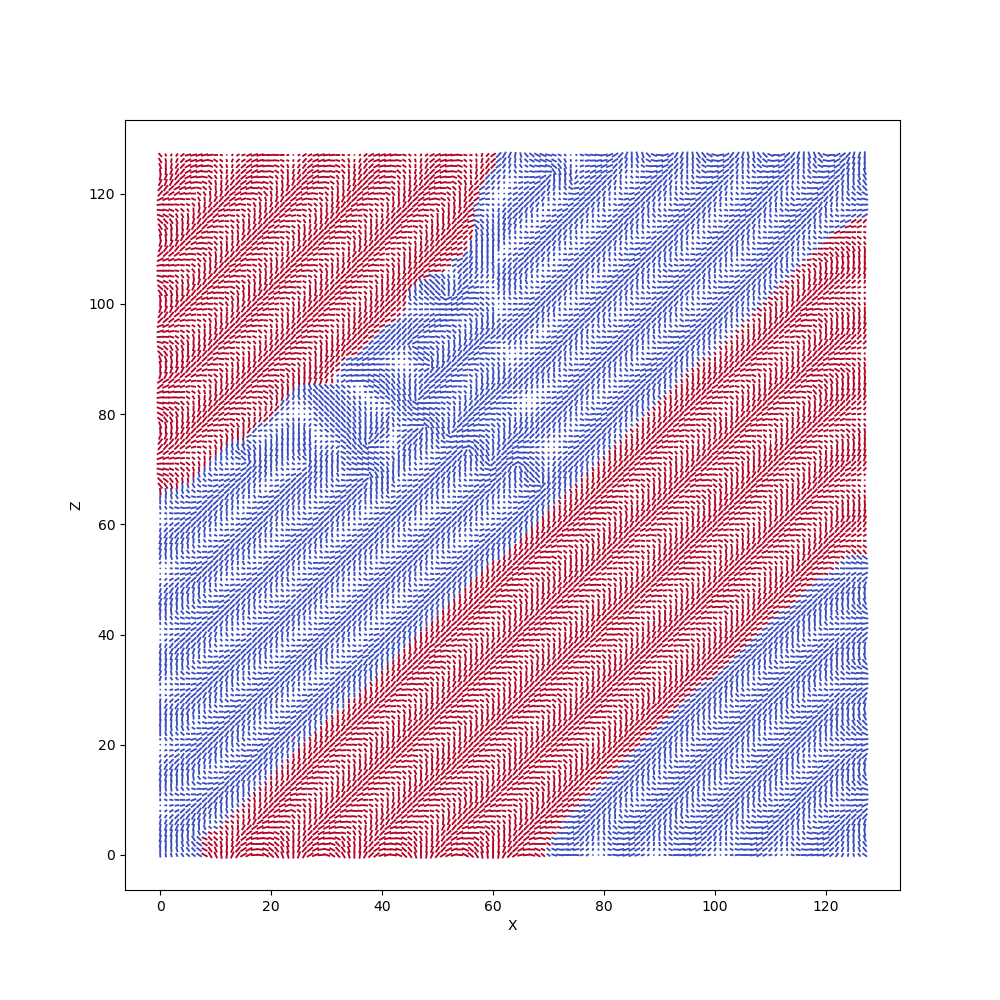

In [2]:
datafile = datafiles[120] #371,242
print(datafile)
data = np.load(datafile)
ni,nj,nk = data['nx'].shape
X,Z = np.meshgrid(np.arange(0,ni),np.arange(0,nk))
mp = int(np.floor(nj/2))
u = data['nx'][:,mp,:]
v = data['ny'][:,mp,:]
w = data['nz'][:,mp,:]
s_color = data['s'][:,mp,:]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.quiver(X,Z,u,w,s_color,pivot='mid',headlength=0,headwidth=0,headaxislength=0,scale_units='xy',scale=0.75,cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Z')
plt.plot()

In [3]:
datafile = datafiles[120]
print(datafile)
data = np.load(datafile)
ni,nj,nk = data['nx'].shape
 
nshells = 16
g,c = calc_s_corr(np.array(data['s']),nshells)
print(g)
print(c)

../data/pdanneal/pdanneal_K1.0_kbt0.05/pdanneal_K1.0_kbt0.05_data.npz
[0.98527526 0.95275202 0.92981049 0.90586168 0.88167571 0.85856051
 0.83489422 0.8126696  0.78838869 0.76464809 0.74099127 0.7174496
 0.69504221 0.66871439 0.64579554 0.62253708]
[2.09715200e+06 5.36458160e+07 1.34704080e+08 3.18232056e+08
 4.65558264e+08 8.06058112e+08 9.13109240e+08 1.41586510e+09
 1.64179651e+09 2.18961149e+09 2.51265806e+09 2.96753088e+09
 3.55219338e+09 4.21437552e+09 4.46331842e+09 5.33715887e+09]


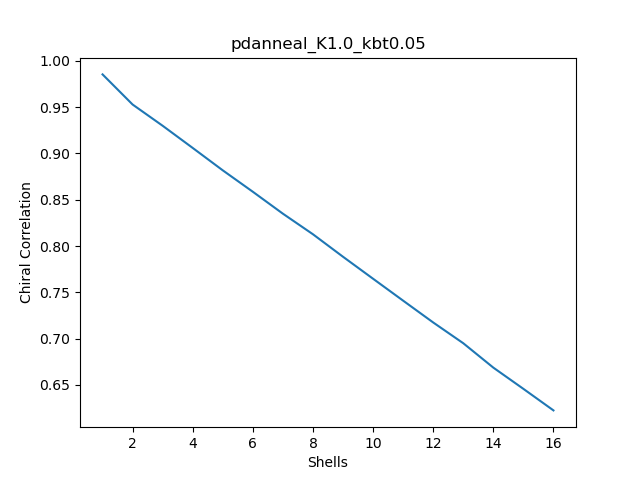

In [18]:
plot_s_corr(datafile,g,savedir="test")

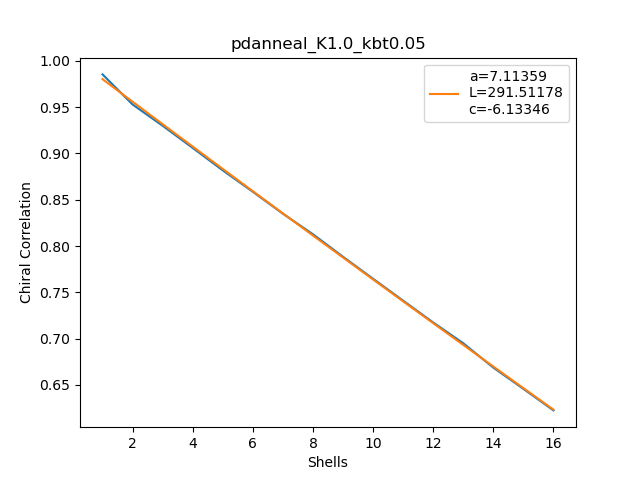

In [21]:
plot_corr_fitc(datafile,g,savedir="test")